In [78]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" #HEADER_LEN,X_DIM,Y_DIM,X_left_boundry,X_right_boundry,Y_left_boundry,Y_right_boundry
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" # frame rate, shutter delay, and interseted position 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers

In [79]:
folder = "/Users/chiaentsai/Library/CloudStorage/Box-Box/MURI-SARA/Thermoreflectance/Joanne/CHESS/0130_2023"

In [80]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)

[4, 28, 2, 2, 18, 2, 12, 1, 8, 5, 41]


In [84]:
Si_melting_W = {
    '103': 41.5,
    '13': 35.4,
    '155': 43.7,
    '190': 45.5,
    #'20': 35.5,
    '234': 47,
    '30': 36.3,
    '352': 52.2,
    '45': 37.1,
    '68': 39.2,
    #'9': 35.3 
    
}

In [85]:
gold_melting_W = {
    '103': 37,
    '13': 30.2,
    '155': 38.9,
    '190': 40.3,
    #'20': 30.8,
    '234': 41.9,
    '30': 31.9,
    '352': 46.2,
    '45': 33.5,
    '68': 35.2,
    #'9': 29.9
    
}

In [86]:
v_list = ['103','13', '155', '190','234','30','352','45', '68']
Dict_1 = dict((k, fivemm_files[k][5:]) for k in v_list) # not included 0W files
back_intensity_list_1 = []
for key in fivemm_files:
    if key in v_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_1.append(back_intensity_list[index])
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_1[i], gaus, gaus)
        con.append(val)
    dRoverR_1.append(con)

In [87]:
power_used = {
        '103':[27+2*p for p in range(0,len(dRoverR_1[v_list.index('103')]),1)], 
        '13':[21+2*p for p in range(0,len(dRoverR_1[v_list.index('13')]),1)], 
        #'20':[23+2*p for p in range(0,len(dRoverR_1[v_list.index('20')]),1)],
        '155':[27+2*p for p in range(0,len(dRoverR_1[v_list.index('155')]),1)],
        '190':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('190')]),1)], 
        '234':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('234')]),1)],
        '30':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('30')]),1)], 
        '352':[31+2*p for p in range(0,len(dRoverR_1[v_list.index('352')]),1)], 
        '45':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('45')]),1)], 
        '68':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('68')]),1)]
        #'9':[21+2*p for p in range(0,len(dRoverR_1[v_list.index('9')]),1)]
          
        }


### Plot all frames dR/R

In [ ]:
for i, (key, value) in enumerate(all_files.items()):
    power = [int(x) for x in power_list[i]][1:]
    files = all_files[key]
    
    for p in power:
        dR_list = []
        for file in tqdm(files):
            if "_{}W_".format(p) in str(file):
                print(str(file))
                dR = get_peak_dRoverR(file, back_intensity_list[i], gaus, gaus)
                dR_list.append(dR)
                
        #convert the frame number to position
        #x = [(frame-2.7)*int(key)/92.59 for frame in range(1,len(temp_list)+1)] 
        
        x = [frame for frame in range(0,len(dR_list))] 
        
        
        plt.plot(x, dR_list, marker="o")
        
        #limit temperature to 1500C
        #plt.ylim(0,1500)
        
        #limit position to 1-10mm
        #plt.xlim(0,5)

    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_vs_frame/{}mmpersec.png".format(key), format="PNG")
    plt.close()

### Plot all powers dR/R for each veloty

In [88]:
for i, v in enumerate(list(Si_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()


### get kappa (use glod and Si melting power)

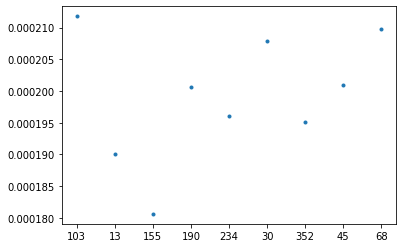

In [91]:
# gold and Si melt
import scipy.optimize
kappa_avg = []
for i, v in enumerate(list(Si_melting_W.keys())):
    popt, pcov = curve_fit(expo, power_used[v], dRoverR_1[i], p0 = [1, 0.00000000838, 1], maxfev = 10000)
    #a, b, c = popt
    plt.plot(power_used[v], dRoverR_1[i], '.')
    y_pred = [expo(j, *popt) for j in power_used[v]]
    plt.plot(power_used[v], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_Si&gold_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    
    
    fun = lambda k: (expo(Si_melting_W[v], *popt) - (1410-21)*k)**2 + (expo(gold_melting_W[v], *popt) - (1064-21)*k)**2
    res = scipy.optimize.minimize(fun, 0.00016)
    temp_pred = [expo(j, *popt)/res.x for j in power_used[v]]
    plt.plot(power_used[v], temp_pred)
    
    plt.plot(Si_melting_W[v], 1410, marker="o",color = 'r', label='Si')
    plt.plot(gold_melting_W[v], 1064, marker="o", color = 'g', label='gold')
    plt.legend(loc="upper left")
    plt.xlabel("power")
    plt.ylabel("temperature")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_gold_Si_fit/{}mm.png".format(v), format="PNG")
    plt.close()
    
#     f = expo(Si_melting_W[v], *popt)
#     gold_m = 1410
#     dT = gold_m - 21
#     kappa = f / dT
    kappa_avg.append(float(res.x))
    
Dict_kappa_avg = dict(zip(list(Si_melting_W.keys()),kappa_avg))

plt.plot(list(Si_melting_W.keys()), kappa_avg, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/0130_kappa_gold&Si.png", format="PNG")

In [92]:
con = 0
for i, v in enumerate(Dict_kappa_avg.keys()):
    con = con + Dict_kappa_avg[v]
kappa_avg = con / len(Dict_kappa_avg)
kappa_avg

0.00019919975209590292

In [93]:
peak_temp = []
for i, v in enumerate(list(Si_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_avg[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(Si_melting_W.keys()),peak_temp))

## fit plane f(power, log10 velocity) = Tpeak 

### The one I sent to them

In [95]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 5.10348097e+02 -9.42988739e+01 -8.27359789e+02  9.36267138e+01
  1.68728213e+03  1.13004963e+00  2.35634551e-02  3.99151018e+00]
1077.414935858704


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_9385/507234216.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [59]:
# from sympy import solve
# from sympy.abc import y, x, z, a, b, c, d, e, f, g, h

# a, b, c, d, e, f, g, h=  5.30354554e+02, -9.60250760e+01, -7.98869136e+02 , 9.13980490e+01, 1.35226042e+03 , 1.11308546e+00 , 2.22079583e-02 , 3.88779414e+00

# solve(function([x,y], a, b, c, d, e, f, g, h) - z, x)



### converter

In [17]:
parameters_T = np.array([ 5.30354554e+02, -9.60250760e+01, -7.98869136e+02 , 9.13980490e+01,
  1.35226042e+03 , 1.11308546e+00 , 2.22079583e-02 , 3.88779414e+00])

def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_T
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])

In [18]:
get_power(88200/352, 1064)

46.311040925364225

# plot temperature vs power

In [96]:
import matplotlib.pyplot as plt
%matplotlib

for velocity in np.unique(y_data):
    mask = y_data == velocity
    plt.plot(x_data[mask], z_data[mask], label = str(round(np.exp(y_data[mask][0])))+'mm/s')
    plt.legend()

Using matplotlib backend: MacOSX


## fit plane f(Tpeak, log tau) = power (beamwidth needed) 要改

 ### don't use this, should just use inverse function...

In [21]:
beamwidth = 88200

import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[tau,T,P])]
    points.append(point)


x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # tau/dwell time
        y_data.append(item[1]) # T
        z_data.append(item[2]) # power
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = y_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters_3, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=100000)
print(parameters_3)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters_3)

z_predicted = function([x_data, y_data], *parameters_3)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('ln tau/dwell time', fontsize=30, labelpad=40)
axes.set_ylabel('Tpeak - Celsius',fontsize=30, labelpad=40)
axes.set_zlabel('Power - W', fontsize=30, labelpad=40)
axes.set_ylim(400, 1400)
#axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_4269/4149000367.py:32: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


[ 4.58541688e+00  8.27490988e-04 -4.54608962e+00  1.00031164e+00
 -1.93052376e+00  2.09456701e+01  2.79200239e+01]
1.9500024414102124


In [22]:
import numpy as np
from scipy.optimize import leastsq

parameters_3 = np.array([ 4.58541688e+00 , 8.27490988e-04, -4.54608962e+00,  1.00031164e+00,
 -1.93052376e+00 , 2.09456701e+01 , 2.79200239e+01])

def get_power_3(dwell, Tpeak):
    lntau = np.log(dwell)
    the_input = [lntau,Tpeak]
    a, b, c, d, e, f, g = parameters_3
    
    return function(the_input, a, b, c, d, e, f, g)

In [24]:
get_power_3(88200/352, 1064)

43.921212855997354

# Invertible function

In [88]:
# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y)*x**2.5 + (c+d*y) + e

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

[ 3.35953767e-01 -4.56819427e-02 -4.19905626e+06  4.48100862e+01
  4.19888221e+06]
1879.5946362863392


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_12673/690333852.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [90]:
from sympy import solve
from sympy.abc import y, x, z, a, b, c, d, e

a, b, c, d, e= 3.35953767e-01, -4.56819427e-02, -4.19905626e+06 , 4.48100862e+01, 4.19888221e+06
solve(function([x,y], a, b, c, d, e ) - z, x)


[246475.015135061*(-(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2 - 0.726542528005361*I*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2)**2,
 246475.015135061*(-(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2 + 0.726542528005361*I*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2)**2,
 340620.09353901*(0.324919696232906*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.00574547543809864*z/(22840971350.0*y - 167976883500.0) - 1/(22840971350.0*y - 167976883500.0))**0.2 - I*(0.257455249641183*y/(22840971350.0*y - 167976883500.0) - 0.005745

# lateral temperature profile

In [97]:
dRoverR_allpoints = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_dR_over_R(file, back_intensity_list_1[i])
        con.append(val)
    dRoverR_allpoints.append(con)
    
dRoverR_lines = []
for velo in dRoverR_allpoints:
    con_1 = []
    for R in velo:
        val = R[round((X_right_boundry-X_left_boundry)/2),:]
        con_1.append(val)
    dRoverR_lines.append(con_1)

temp_lines = []    
for i, v in enumerate(list(Dict_1.keys())):
    con_2 = []
    velo = dRoverR_lines[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_avg[v])
        con_2.append(temp)
    temp_lines.append(con_2)
    
parameters = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    velo = temp_lines[i]
    for t in velo:
        [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
        con.append([height, x_0, sigma1, sigma2])
    parameters.append(con)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# fit sigma1, sigma2 plane

In [98]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

beamwidth = 88200

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g


points_1 = []
points_2 = []

for i, v in enumerate(list(Si_melting_W.keys())):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    sigma1 = [el[2] for el in parameters[i]]
    sigma2 = [el[3] for el in parameters[i]]
    point1 = [list(x) for x in zip(*[P,tau,sigma1,T])]
    points_1.append(point1)
    point2 = [list(x) for x in zip(*[P,tau,sigma2,T])]
    points_2.append(point2)

    
x_data = []
y_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # tau
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[3]) # Tpeak
        

for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
        
        
x_data, y_data, z_data_1, z_data_2, t_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data)


mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]


parameters_1, covariance_1 = curve_fit(function, [x_data, y_data], z_data_1,  maxfev=1000000)
parameters_2, covariance_2 = curve_fit(function, [x_data, y_data], z_data_2,  maxfev=1000000)

print(parameters_1)
print(parameters_2)

model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z1 = function(np.array([X, Y]), *parameters_1)
Z2 = function(np.array([X, Y]), *parameters_2)

z_predicted_1 = function([x_data, y_data], *parameters_1)
z_predicted_2 = function([x_data, y_data], *parameters_2)

differences_1 = np.subtract(z_data_1, z_predicted_1)
differences_2 = np.subtract(z_data_2, z_predicted_2)

squared_differences_1 = np.square(differences_1)
squared_differences_2 = np.square(differences_2)

mse_1 = squared_differences_1.mean()
mse_2 = squared_differences_2.mean()
print(mse_1)
print(mse_2)

Using matplotlib backend: MacOSX
[-1.40145810e+04 -3.26969897e-03 -1.40113862e+04  5.01639131e-03
  1.54685580e+04 -1.46848957e+05 -1.95501057e+08]
[ 1.20642045e+02  2.67799592e-03  1.20558289e+02  1.01468670e+00
 -1.08645002e+01 -1.53372006e+04  2.05449540e+03]
3733394573.73632
42097.67573159603


In [99]:
f1 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes1 = Axes3D(f1)

axes1.plot_surface(X, Y, Z1, cmap=cm.hot, alpha=0.2)
axes1.scatter(x_data, y_data, z_data_1, s=500)

axes1.set_title('Scatter Plot')
axes1.set_xlabel('power - W', fontsize=30, labelpad=40)
axes1.set_ylabel('tau',fontsize=30, labelpad=40)
axes1.set_zlabel('sigma1', fontsize=30, labelpad=40)

axes1.tick_params(axis='both', which='major', labelsize=30)
 
plt.show()
print(mse_1)

3733394573.73632


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_9385/2512510063.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes1 = Axes3D(f1)


In [100]:
f2 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes2 = Axes3D(f2)

axes2.plot_surface(X, Y, Z2, cmap=cm.hot, alpha=0.2)
axes2.scatter(x_data, y_data, z_data_2, s=500)

axes2.set_title('Scatter Plot')
axes2.set_xlabel('power - W', fontsize=30, labelpad=40)
axes2.set_ylabel('tau',fontsize=30, labelpad=40)
axes2.set_zlabel('sigma2', fontsize=30, labelpad=40)

axes2.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse_2)

42097.67573159603


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_9385/3592995763.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes2 = Axes3D(f2)
